In [66]:
import torch
import torchvision
from sklearn.datasets import load_iris
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

1. Porniti de la un dataset artificial generat cu ajutorul metodei make_classification din sklearn (minim 10000 de exemple, cu cel putin 100 de feature-uri relevante, grupate in cel putin 3 clase) sau puteti folosi un toy-dataset de aici.

In [47]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        super().__init__()
        self.data = data
        self.transform = transform

    # urmatoarele doua metode trebuie implementate
    def __getitem__(self, k):
        """Returneaza al k-lea exemplu din dataset"""
        return (
            self.data["data"][k],
            self.data["target"][k]
        )

    def __len__(self):
        """Returneaza dimensiunea datasetului"""
        return self.data["data"].shape[0]

data = load_iris()
list(data.target_names)
list(data.feature_names)

data = MyDataset(data, transform=torchvision.transforms.ToTensor())

2. Definiti un model cu cel putin 3 layere lineare, dintre care ultimul are dimensiunea outputului egala cu numarul de clase. Aplicati dupa fiecare layer linear (cu exceptia ultimului) o functie de activare aleasa de voi.

In [80]:
model = torch.nn.Sequential(
    torch.nn.Linear(4, 2, dtype=torch.float64),
    torch.nn.ReLU(),
    torch.nn.Linear(2, 2, dtype=torch.float64),
    torch.nn.ReLU(),
    torch.nn.Linear(2, 3, dtype=torch.float64),
)

model_dropout = torch.nn.Sequential(
    torch.nn.Linear(4, 2, dtype=torch.float64),
    torch.nn.Dropout(p=0.2),
    torch.nn.ReLU(),
    torch.nn.Linear(2, 2, dtype=torch.float64),
    torch.nn.Dropout(p=0.2),
    torch.nn.ReLU(),
    torch.nn.Linear(2, 3, dtype=torch.float64),
)


3. Impartiti datasetul in 80% train, 10% validare si 10% test. Creati cele trei dataloadere corespunzatoare fiecarui split.

In [48]:
train_data, validation_data, test_data = torch.utils.data.random_split(data, [0.8, 0.1, 0.1])

print(len(train_data))
print(len(validation_data))
print(len(test_data))



120
15
15


4. Definiti functia de loss (cross-entropy) si un optimizer (SGD, Adam, etc.).

In [27]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

5. Antrenati modelul pentru mai multe epoci pe datele de train. La finalul fiecarei epoci evaluati performanta modelului pe datele de validare. Monitorizati la fiecare epoca eroarea medie si acuratetea pentru predictiile facute pe datele de train si separat pe datele de validare, pentru ca in cazul in care observati situatia de *overfit* sa puteti opri antrenarea.

In [84]:
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=5, shuffle=True)
validation_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=5)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=5)

epochs = 5

def train_loop(model):

    best_val_loss = 100000
    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []

    for epoch in range(epochs):

        train_loss = 0
        true_labels = []
        predicted_labels = []

        model.train()

        for batch in train_dataloader:

            optimizer.zero_grad()

            data = batch[0]
            labels = batch[1]
            true_labels.extend(labels.tolist())
            b_size = data.size(0)

            output = model(data)
            predicted_labels.extend(output.max(1)[1].tolist())
            loss = loss_fn(output, labels)
            loss.backward()
            train_loss += loss
            optimizer.step()

        train_loss /= len(train_dataloader)
        train_acc = metrics.accuracy_score(true_labels, predicted_labels)
        train_loss_list.append(train_loss.detach())
        train_acc_list.append(train_acc)

        print(f"Train:\tMean loss: {train_loss:.4f}\tAccuracy: {train_acc:.4f}")

        val_loss = 0
        true_labels = []
        predicted_labels = []

        model.eval()

        with torch.no_grad():

            for batch in validation_dataloader:
                data = batch[0]
                labels = batch[1]
                b_size = data.size(0)

                output = model(data)
                loss = loss_fn(output, labels)

                val_loss += loss.item()
                true_labels.extend(labels.tolist())
                predicted_labels.extend(output.max(1)[1].tolist())

        val_loss /= len(validation_dataloader)
        val_acc = metrics.accuracy_score(true_labels, predicted_labels)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)
        print(f"Validation:\tMean loss: {val_loss:.4f}\tAccuracy: {val_acc:.4f}\n")

        # 6. Salvati modelul cu cea mai buna eroare de validare, calculata la finalul epocii respective.
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "model.pt")

    return train_loss_list, train_acc_list, val_loss_list, val_acc_list


In [88]:
tll, tal, vll, val = train_loop(model)

Train:	Mean loss: 1.1034	Accuracy: 0.3417
Validation:	Mean loss: 1.1080	Accuracy: 0.2667

Train:	Mean loss: 1.1034	Accuracy: 0.3417
Validation:	Mean loss: 1.1080	Accuracy: 0.2667

Train:	Mean loss: 1.1034	Accuracy: 0.3417
Validation:	Mean loss: 1.1080	Accuracy: 0.2667

Train:	Mean loss: 1.1034	Accuracy: 0.3417
Validation:	Mean loss: 1.1080	Accuracy: 0.2667

Train:	Mean loss: 1.1034	Accuracy: 0.3417
Validation:	Mean loss: 1.1080	Accuracy: 0.2667



7. Plotati pe acelasi grafic evolutia erorii de train si a erorii de validare la finalul fiecarei epoci. Plotati in alt grafic evolutia acuratetii pe datele de train si pe cele de validare.

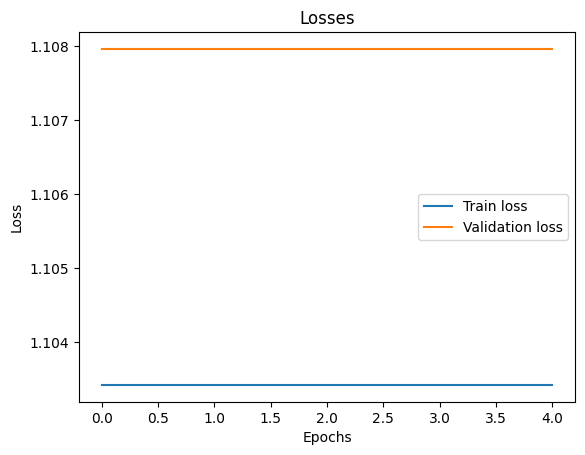

In [89]:
x_values = range(len(tll))

fig, ax = plt.subplots()
ax.plot(x_values, tll, label="Train loss")
ax.plot(x_values, vll, label="Validation loss")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_title("Losses")
ax.legend()
plt.show()

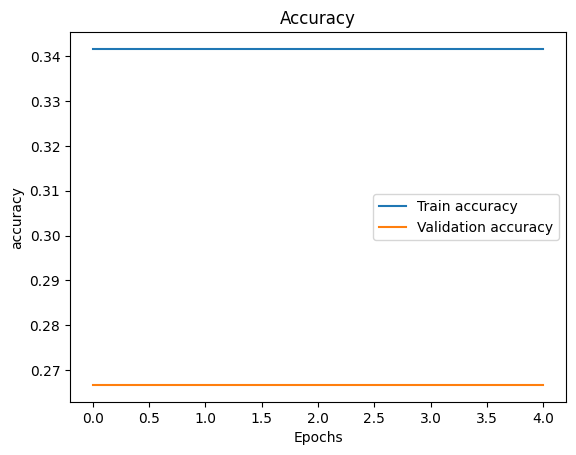

In [90]:
fig, ax = plt.subplots()
ax.plot(x_values, tal, label="Train accuracy")
ax.plot(x_values, val, label="Validation accuracy")
ax.set_xlabel("Epochs")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy")
ax.legend()
plt.show()

8. Evaluati modelul (eroare, acuratete, macro-f1, etc.) pe datele de test.

In [94]:
def test(model):
    test_loss = 0
    true_labels = []
    predicted_labels = []
    with torch.no_grad():

        for batch in test_dataloader:
            data = batch[0]
            labels = batch[1]
            b_size = data.size(0)

            output = model(data)
            loss = loss_fn(output, labels)

            test_loss += loss.item()
            true_labels.extend(labels.tolist())
            predicted_labels.extend(output.max(1)[1].tolist())

    test_loss /= len(validation_dataloader)
    test_acc = metrics.accuracy_score(true_labels, predicted_labels)
    test_macrof1 = metrics.f1_score(true_labels, predicted_labels, average="macro")

    print(f"Loss: {test_loss}\nAccuracy: {test_acc}\nMacro F1 score: {test_macrof1}")

In [95]:
test(model)

Loss: 1.1060722116948136
Accuracy: 0.3333333333333333
Macro F1 score: 0.16666666666666666


9. Incercati sa adaugati dupa fiecare layer din model (cu exceptia ultimului) dropout cu un $p$ ales de voi. Analizati daca performanta unui model antrenat astfel este mai buna.

In [96]:
tll, tal, vll, val = train_loop(model_dropout)
test(model_dropout)

Train:	Mean loss: 1.2141	Accuracy: 0.3167
Validation:	Mean loss: 1.1612	Accuracy: 0.4000

Train:	Mean loss: 1.2485	Accuracy: 0.3167
Validation:	Mean loss: 1.1612	Accuracy: 0.4000

Train:	Mean loss: 1.2257	Accuracy: 0.3167
Validation:	Mean loss: 1.1612	Accuracy: 0.4000

Train:	Mean loss: 1.2343	Accuracy: 0.3167
Validation:	Mean loss: 1.1612	Accuracy: 0.4000

Train:	Mean loss: 1.2291	Accuracy: 0.3167
Validation:	Mean loss: 1.1612	Accuracy: 0.4000

Loss: 1.1381870722482847
Accuracy: 0.4
Macro F1 score: 0.1904761904761905


Performanta pare putin mai buna. Acuratetea pe test este mai mare, desi loss-ul este mai mare.